## Deep Learning
### <font color='blue'>Architectures CNN/ Fine-tuning</font>

---
**Importation des bibliothèques**

In [ ]:
import tensorflow as tf

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Assemblage Google Drive dans Colaboratory
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**1/** 	Créer un bloc de type *Functional* nommé $conv\_pool\_resnet50$ qui contient les couches de convolution et de pooling de l’architecture <b><font color='red' size=3>ResNet50</font></b> préentraînée sur le dataset *ImageNet* pour une entrée de taille (48,48,3)

In [ ]:
conv_pool_resnet50= tf.keras.applications.ResNet50(include_top=False,input_shape=(48,48,3))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**2/** 	Créer un bloc de type *Sequential* nommé $data\_augmentation$ qui généré une variété d’échantillons en appliquant des transformations aléatoires aux images. Ces transformations doivent inclure une rotation de $30°$, un zoom $x50$, et un pivotement $horizontal$

In [ ]:
data_augmentation =tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.3),tf.keras.layers.RandomZoom(0.5)])

**3/** 	Écrire une fonction nommée $garbage\_resnet()$ qui permet de créer le modèle $cls\_garbage$ décrit dans la **Figure 1**

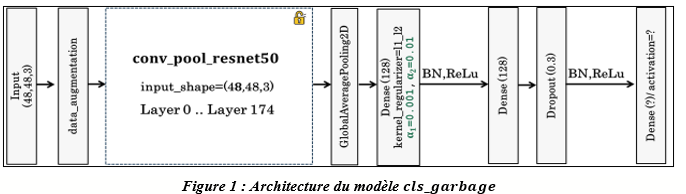

In [ ]:
def garbage_resnet():
  input = tf.keras.Input(shape=(48,48,3))
  x =data_augmentation(input)
  x = conv_pool_resnet50(x,training=True)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(128,tf.keras.regularizers.l1_l2(l1=0.001,l2=0.01))(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation("relu")(x)
  x = tf.keras.layers.Dense(128)(x)
  x =tf.keras.layers.Dropout(0.3)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.Activation("relu")(x)
  output = tf.keras.layers.Dense(6,activation="softmax")(x)
  return tf.keras.Model(input,output)



**4/** 	Télécharger les poids du modèle $cls\_garbage$ déjà entraîné sur la base de données ***garbage*** à partir du fichier ***garbage_resnet.h5***. Puis, représenter le résumé de l’architecture du modèle $cls\_garbage$

In [ ]:
cls_garbage=garbage_resnet()

cls_garbage.load_weights("/content/drive/MyDrive/garbage_resnet.h5")

cls_garbage.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2, 2, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,868,294 (91.05 MB)

 Trainable params: 23,814,662 (90.85 MB)

 Non-trainable params: 53,632 (209.50 KB)

In [ ]:
cls_garbage.layers[2].layers[2].input

<KerasTensor shape=(None, 54, 54, 3), dtype=float32, sparse=False, name=keras_tensor_1>

**5/** 	Créer un modèle de type *Functional* nommé $p\_m\_dechets1$, destiné à classer les données en deux catégories: **O** ou **R**, en utilisant les données d’apprentissage issues de la base ***g_déchets***. Ce modèle doit reprendre exactement la même architecture que $cls\_garbage$, <u>à l’exception de la dernière couche, qui devra être remplacée par un seul neurone avec une activation sigmoïde</u>

<b><font color='blue' size=3>NB. Ne compilez ni n’entraînez le modèle à ce stade</font></b>


In [ ]:
input = tf.keras.Input(shape=(48, 48, 3))
extract= tf.keras.Model(cls_garbage.layers[1].input,cls_garbage.layers[10].output)
x =extract(input,training=True)
output = tf.keras.layers.Dense(1, activation=tf.sigmoid)(x)
p_m_dechets1 = tf.keras.Model(input, output)

p_m_dechets1.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_4 (Functional)       │ (None, 128)            │    23,867,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,867,649 (91.05 MB)

 Trainable params: 23,814,017 (90.84 MB)

 Non-trainable params: 53,632 (209.50 KB)

In [ ]:
p_m_dechets1.layers[1].summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 48, 48, 3) │          0 │ input_layer_5[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2, 2,      │ 23,587,712 │ sequential[3][0]  │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[2][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │    262,272 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     16,512 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dropout_2[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,867,520 (91.05 MB)

 Trainable params: 23,813,888 (90.84 MB)

 Non-trainable params: 53,632 (209.50 KB)

In [ ]:
len(p_m_dechets1.layers[1].layers[2].layers)

175

<b><font color='green' size=3>-------------------------------------------------------------</font></b>

Dans le même contexte, un autre modèle nommé $p\_m\_dechets2$ est présenté dans la **Figure 2**, visant à classer les déchets en deux catégories : **O** ou **R**

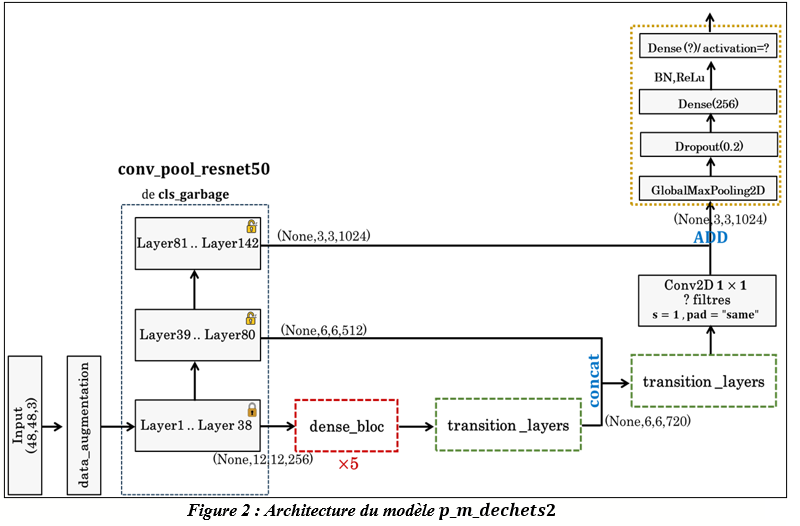


**6/** 	Définir une fonction $dense\_bloc(x)$ qui prend en paramètre un tenseur $x$ et retourne un modèle de type *Functional* représentant l’architecture d’un **dense block**, comme illustré dans la **Figure 3**

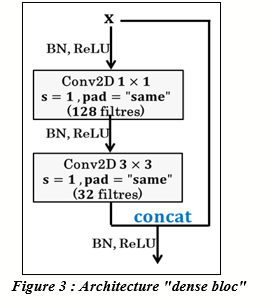

In [ ]:
def dense_bloc(x):
 y=tf.keras.layers.BatchNormalization()(x)
 y=tf.keras.layers.Activation("relu")(y)
 y=tf.keras.layers.Conv2D(filters=128,
    kernel_size=(1, 1),
    strides=1,
    padding="same")(y)
 y=tf.keras.layers.BatchNormalization()(y)
 y=tf.keras.layers.Activation("relu")(y)
 y=tf.keras.layers.Conv2D(32, (3,3), 1, "same")(y)
 y=tf.keras.layers.Concatenate()([x,y])
 y=tf.keras.layers.BatchNormalization()(y)
 y=tf.keras.layers.Activation("relu")(y)
 return tf.keras.Model(inputs=x, outputs=y)

**7/** 	Définir une fonction $transition\_layers(x)$ qui prend en paramètre un tenseur $x$ et retourne un modèle de type *Functional* représentant l’architecture d’un bloc de transition, composé de *deux couches* : une couche de convolution $1 \times 1$ permettant de réduire de moitié le nombre de canaux de $x$, suivie d’une couche de **Average Pooling** avec $pool\_size=(2,2)$ et $stride=2$ pour réduire la taille spatiale (**Figure 4**)

In [ ]:
def transition_layers(x):
 y=tf.keras.layers.Conv2D(x.shape[-1]//2,(1,1),1,"same")(x)
 y=tf.keras.layers.BatchNormalization()(y)
 y=tf.keras.layers.Activation("relu")(y)
 y=tf.keras.layers.AveragePooling2D((2, 2), padding='same')(y)
 return tf.keras.Model(x,y)


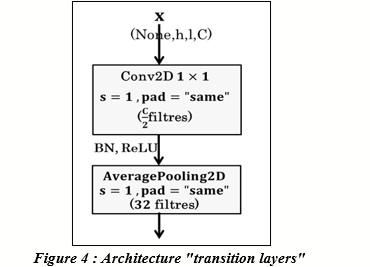

**8/** 	Télécharger ***p_m_dechets1.h5*** à partir de \"/content/drive/MyDrive/\" puis créer une fonction $build\_p\_m\_dechets2()$ qui permet de construire un CNN de type *Functional*, appelé $p\_m\_dechets2$ en adoptant l’architecture présentée dans la **Figure 2**

In [ ]:
def build_p_m_dechets2():
  input= tf.keras.Input(shape=(48, 48, 3))
  x= data_augmentation(input)
  conv_pool_resnet50 = cls_garbage.layers[2]
  extract1= tf.keras.Model(input=conv_pool_resnet50.layers[1], output=conv_pool_resnet50.layers[38])
  extract1.trainble = False

  y = extract1(x)
  for i in range(5):
    y = dense_bloc(y)(y)

  extract2= tf.keras.Model(input=conv_pool_resnet50.layers[39], output=conv_pool_resnet50.layers[80])
  extract2.trainble = True
  extract2 = extract2(y)

  extract3= tf.keras.Model(input=conv_pool_resnet50.layers[81], output=conv_pool_resnet50.layers[142])
  extract3.trainble = True
  extract3(extract2)

  y=transition_layers(y)(y)
  y=tf.keras.layers.Concatenate()([extract2,y])
  y=transition_layers(y)(y)
  y=tf.keras.layers.Conv2D(1024, (1,1), 1, "same")(y)

  z=tf.keras.layers.Add()([extract3,y])

  z= tf.keras.layers.GlobalAveragePooling2D()(z)
  z= tf.keras.layers.Dropout(0.2)(z)
  z= tf.keras.layers.Dense(256)(z)
  z= tf.keras.layers.BatchNormalization()(z)
  z=tf.keras.layers.Activation("relu")(z)
  output = tf.keras.layers.Dense(1, activation="sigmoid")(z)
  return tf.keras.Model(input,output)

p_m_dechets2=build_p_m_dechets2()
# 3LEH ADAM ? 3LEH BINARY CROSS ENTROPY MOUCH SPARSE?
p_m_dechets2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


**9/** 	Charger les données d’apprentissage, de validation et de test de la base de données **g\_déchets** respectivement dans des conteneurs de type PrefetchDataset $train\_ds$, $val\_ds$ et $test\_ds$ en spécifiant la taille des images en mode **RGB** à **(48,48,3)** pixels et en utilisant une *taille de batch* de $64$. Pour créer le jeu de données de validation, sélectionner aléatoirement $20\%$ des données d’apprentissage et enregistrer-les dans $val\_ds$

<b><font color='blue' size=3>NB. Forcer la conservation des données en cache dans la mémoire et activer le traitement parallèle des lots pour les données d’apprentissage, de validation et de test</font></b>



In [ ]:
#cd /content/drive/MyDrive

In [ ]:
#!unzip g_dechets.zip

In [ ]:
unzip g_dechets.zip
%cd /content/drive/MyDrive/g_dechets
%ls

/content/drive/MyDrive/g_dechets
Test/  Train/


In [ ]:
# Load training and validation datasets
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    directory="Train",
    image_size=(48, 48),
    color_mode='rgb',  # ✅ Fixed quote
    validation_split=0.2,
    seed=123,
    subset="both",
    batch_size=64
)

# Load test dataset (no validation split needed here)
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory="Test",
    image_size=(48, 48),
    color_mode='rgb',
    batch_size=64
)

Found 11816 files belonging to 2 classes.
Using 9453 files for training.
Using 2363 files for validation.
Found 5064 files belonging to 2 classes.


In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

**10/** Entraîner le modèle $p\_m\_dechets2$ sur $10$ époques en utilisant l’optimiser *adam*. À chaque époque, calculer l’*accuracy* sur l’ensemble d’apprentissage ainsi que sur l’ensemble de validation ($val\_accuracy$).
Mettre en place un mécanisme d’**early stopping** en cas d’absence d’amélioration $val\_accuracy$ pendant $3$ époques consécutives. Sauvegarder les poids du meilleur modèle (en termes de $val\_accuracy$) dans le répertoire \"/content/drive/MyDrive/\"sous le nom ***p_m_dechets2.weights.h5***


In [ ]:
# Construction du modèle
p_m_dechets2 = build_p_m_dechets2()

# Compilation du modèle
p_m_dechets2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Définition des callbacks : early stopping et sauvegarde du meilleur modèle
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/p_m_dechets2.weights.h5",
    monitor='val_accuracy',
    mode='max',
    save_weights_only=True,
    save_best_only=True,
    verbose=1
)

# Entraînement du modèle
p_m_dechets2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[earlystop, checkpoint]
)

**11/** Importer ***test_déchets.csv*** dans un DataFrame nommé $df\_test$. Ensuite, utiliser le modèle $p\_m\_dechets2$ pour prédire les classes et représenter la matrice de confusion associée à $df\_test$

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Chargement des données de test
df_test = pd.read_csv('/content/drive/MyDrive/test_dechets.csv')
test = df_test.iloc[:, :-1].values.reshape(len(df_test), 48, 48, 3)

# Création d'un dataset TensorFlow pour les prédictions
batchDs_test = tf.data.Dataset.from_tensor_slices(test).batch(64)

# Chargement des poids du modèle entraîné
p_m_dechets2.load_weights('/content/drive/MyDrive/p_m_dechets2.weights.h5')

# Prédictions
pred_probs = p_m_dechets2.predict(batchDs_test)
pred_labels = (pred_probs > 0.5).astype(int).flatten()

# Matrice de confusion
true_labels = df_test.iloc[:, -1].values
cm = confusion_matrix(true_labels, pred_labels)

# Affichage de la heatmap
sns.heatmap(cm, annot=True, fmt='d', cbar=False,
            xticklabels=['O', 'R'], yticklabels=['O', 'R'])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()

In [ ]:
input1= tf.keras.Input(shape=(48, 48, 3))
input2= tf.keras.Input(shape=(48, 48, 3))
y=conv_pool_resnet50(input1,training=True)
x=tf.keras.layers.GlobalMaxPooling2D()(y)
bloc_vgg=tf.keras.Model(conv_pool_vgg16.layers[1].input,
                            conv_pool_vgg16.layers[10].output)
y=bloc_vgg(input2,training=False)
y=tf.keras.layers.DepthwiseConv2D((3,3))(y)
y=tf.keras.layers.Conv2D(512, (1,1),1,"same")(y)
y=tf.keras.layers.BatchNormalization()(y)
y=tf.keras.layers.ReLU()(y)
y=tf.keras.layers.GlobalMaxPooling2D()(y)
z=tf.keras.layers.Concatenate()([x,y])
z=tf.keras.layers.Dense(256)(z)
z=tf.keras.layers.BatchNormalization()(y)
z=tf.keras.layers.ReLU()(y)
output=tf.keras.layers.Dense(3, activation='softmax')(z)
model=tf.keras.Model([input1, input2],output)

In [ ]:
# Chargement des deux datasets d'entraînement
train1 = tf.keras.utils.image_dataset_from_directory(
    directory="Dataset1/Train",
    image_size=(48, 48),
    seed=123,
    batch_size=32
)

train2 = tf.keras.utils.image_dataset_from_directory(
    directory="Dataset2/Train",
    image_size=(48, 48),
    seed=123,
    batch_size=32
)

def to_vect(dataset):
    images = []
    labels = []
    for imgs, lbs in dataset:
        images.extend(imgs.numpy())
        labels.extend(lbs.numpy())
    images = np.array(images)
    labels = np.array(labels)
    return images, labels"

# Conversion des datasets en vecteurs numpy
img_T1, lbs_T1 = to_vect(train1)
img_T2, _      = to_vect(train2)  # labels identiques, donc ignorés ici

# Supposons que vous avez déjà préparé img_V1, img_V2, et lbs_V
# Par exemple : img_V1, img_V2, lbs_V = to_vect(val1), to_vect(val2), ...

# Entraînement du modèle
model.fit(
    [img_T1, img_T2],
    lbs_T1,
    validation_data=([img_V1, img_V2], lbs_V),
    epochs=10  # ou autre paramètre
)